#**Exploratory Data Analysis**

In [1]:
!pip install kats

     |████████████████████████████████| 6.3 MB 5.4 MB/s 
     |████████████████████████████████| 866 kB 46.8 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 310 kB 42.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.0 MB/s 
     |████████████████████████████████| 25.3 MB 84.9 MB/s 
     |████████████████████████████████| 9.8 MB 27.2 MB/s 
     |████████████████████████████████| 26.3 MB 54.4 MB/s 
     |████████████████████████████████| 486 kB 37.9 MB/s 
  Created wheel for kats: filename=kats-0.1.0-py3-none-any.whl size=286607 sha256=3ba6acb2ab8b6465553a3be89c179f7b6f09d8e70c56192bec66bd4f942caa9d
  Stored in directory: /root/.cache/pip/wheels/c8/dd/5b/cc7cb7fc37c5b838c65e504437bba4c1828a3fbb473c0c11be
  Created wheel for fbprophet: filename=fbprophet-0.7-py3-none-any.whl size=6637777 sha256=245f6fc3f307f259b50064eda1504dd02584a53825017d907b58f14d25217f89
  Stored in directory: /root/.cache/pip/wheels/82/e8/a8/53f37f0a409bc

### **Installation and Import**

In [3]:
# Import the packages
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from kats.consts import TimeSeriesData
from kats.detectors.robust_stat_detection import RobustStatDetector
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.detectors.cusum_detection import CUSUMDetector

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')

In [5]:
df = df.dropna()

In [6]:
df.tail()

,Date,SalesVolume
313,2021-02-01,73883.0
314,2021-03-01,102914.0
315,2021-04-01,64632.0
316,2021-05-01,45580.0
317,2021-06-01,41232.0


## **Visualizing the TS Data**

In [5]:
viz_df = df.copy()

**Line Plot**

In [6]:
fig = px.line(viz_df, x='Date', y="SalesVolume")
fig.show()

**Box Plot**

In [7]:
viz_df['year'] = pd.DatetimeIndex(viz_df['Date']).year

In [8]:
fig = px.box(viz_df,x="year",y="SalesVolume")
fig.show()

**Seasonal decomposition**

In [9]:
stl_df = df.set_index('Date')

In [10]:
stl_df.head()

,SalesVolume
Date,
1995-01-01,47639.0
1995-02-01,47880.0
1995-03-01,67025.0
1995-04-01,56925.0
1995-05-01,64192.0


In [11]:
result = seasonal_decompose(stl_df['SalesVolume'],freq=12,model='additive')

In [12]:
stl_df['Seasonal'] = result.seasonal
stl_df['Trend'] = result.trend
stl_df['Residual'] = result.resid
stl_df = stl_df.reset_index()

In [13]:
#Seasonal plot 
fig = px.line(stl_df,x = 'Date', y = 'Seasonal')
fig.show()

In [14]:
#Trend plot 
fig = px.line(stl_df,x = 'Date', y = 'Trend')
fig.show()

In [15]:
#Residual plot 
fig = px.line(stl_df,x = 'Date', y = 'Residual')
fig.show()

## **ADF Test**

In [16]:
adf_test_df = df.set_index('Date').squeeze()

In [17]:
sales_val = adf_test_df.values

In [18]:
result = adfuller(sales_val)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.544328
p-value: 0.105058
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


### Inference:
ADF Statistic: **-2.544328** is  less than Critical Values 1%: **-3.452** which suggests the possibility to reject the null hypothesis making the series stationary

But the p-value is above the threshold of 0.05. Hence running KPSS test to validate the results

## **KPSS Test**

In [19]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

In [22]:
#Stationarity around mean
kpss_test(sales_val)

KPSS Statistic: 0.608930465892383
p-value: 0.021824503100692453
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



In [23]:
#Stationarity around Determinstic Trend
kpss_test(sales_val, regression='ct')

KPSS Statistic: 0.14807356572276226
p-value: 0.04827202856436478
num lags: 17
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



### Inference:
KPSS Statistic: The p-value is consitently below the threshold (0.05) at **0.02** and **0.04** which suggests that we cannont reject the null hypothesis and the series is considered to be **Non-Stationary**

## **Visualizing using ACF and PACF plots**

### **ACF Plot**

In [28]:
viz_corr_df = df.copy()
viz_corr_df = viz_corr_df.set_index('Date')

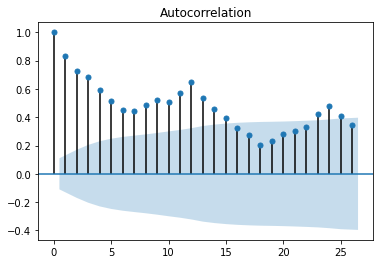

In [29]:
plot_acf(viz_corr_df)
pyplot.show()

### **PACF Plot**

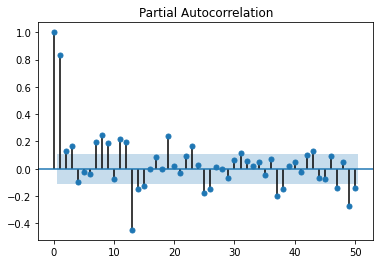

In [31]:
plot_pacf(viz_corr_df, lags=50)
pyplot.show()

## **Changepoint Detection using KATS**

In [7]:
kats_df = df.rename(columns={'Date':'time', 'SalesVolume':'increase'})

In [8]:
tsd = TimeSeriesData(kats_df)

### **BOCPDetector**

[WARNING 12-13 08:01:22] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 12-13 08:01:22] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 12-13 08:01:22] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 12-13 08:01:22] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `T

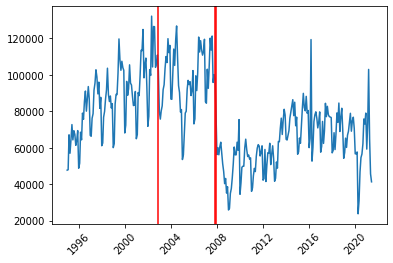

In [10]:
# Initialize the detector
detector = BOCPDetector(tsd)

changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL 
)

# Plot the data
pyplot.xticks(rotation=45)
detector.plot(changepoints)
pyplot.show()

### **RobustStatDetector**

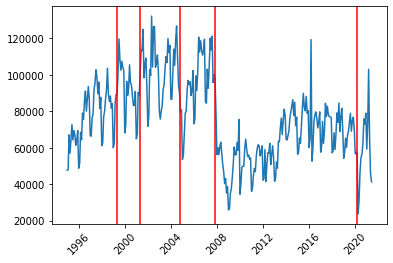

In [11]:
detector = RobustStatDetector(tsd)
change_points = detector.detector()

pyplot.xticks(rotation=45)
detector.plot(change_points)
pyplot.show()